### EE 421/521 Image Processing - Spring 2021-22

## Lecture 10 - Noise Filtering

#### 21 April 2022

In this lecture, you will learn how to implement the following:

1. Adding noise to an image with a given PSNR
2. Filtering a noisy image with an LSI filter
3. Filtering a noisy image with the Local LMMSE filter
4. Filtering a noisy image with a median filter

*Copyright (c) 2020-2022 by Arif Tanju Erdem*

In [8]:
# import necessary packages

# reading/writing image files
from skimage import io
from skimage import color

# displaying images and plots
import matplotlib as mpl
import matplotlib.pyplot as plt

# array operations
import numpy as np

# signal processing operations
from scipy import signal

# mathematical calculations
import math

# random number generation
from scipy.stats import norm

In [9]:
# my function to convert to lumincance, round to nearest integer, 
# truncate to range [0, 255], and then set data

def my_imgLuminance(imgRGB):
    
    # make sure it is a color image
    dim_img = imgRGB.shape[2]    
    assert dim_img >= 3
    
    # get the luminance data
    if dim_img == 3:
        imgLum = color.rgb2gray(imgRGB)
    else:
        # ignore the alpha channel
        imgLum = color.rgb2gray(imgRGB[:,:,0:3])

    imgLum = np.round(imgLum * 255, 0)
    imgLum = np.minimum(imgLum, 255)
    imgLum = np.maximum(imgLum, 0)
    imgLum = imgLum.astype('uint8')
    
    return imgLum

# end of function

In [10]:
# display an image in original size

def my_display_actual_size(img, str_caption):
    
    dpi = mpl.rcParams['figure.dpi']
    height, width = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    # ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
    plt.xticks([]), plt.yticks([])

    plt.title(str_caption)
    plt.show()

    return

# end of function

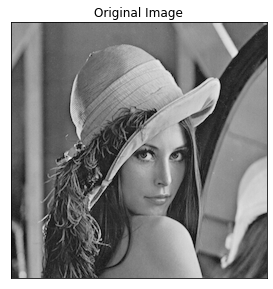

In [11]:
# set image folder
image_folder = r'C:\Users\Metin\Desktop\EE421\Week10'

# read input image 
image_file = r'/lena_256.png'
image_path = image_folder + image_file
imgRGB = io.imread(image_path)

if imgRGB.ndim >= 3:
    # calculate the luminance image
    imgLum = my_imgLuminance(imgRGB)
else:
    imgLum = imgRGB

my_display_actual_size(imgLum,'Original Image')


---------------------------------------------------------------
### **Part 1:** Adding White Gaussian Noise to Image


In [12]:
# calculate the RMSE between two images

def my_RMSE(img1, img2):
    
    assert img1.ndim == img2.ndim
    assert img1.size == img2.size
    
    return math.sqrt(((img1 - img2)**2).sum() / img1.size)
    
# end of function

In [13]:
# get image size
size = 'imgLum'.shape

# Gaussian noise parameters
noise_Mean = 0.0
PSNR = 20.0
noise_Std = 255.0 / (10.0 ** (PSNR/20.0))
print('PSNR = {:.2f} -> Noise Std. Dev. = {:.2f}'.format(PSNR, noise_Std))

# add Gaussian noise to image
imgNoisy = imgLum + norm.rvs(noise_Mean, noise_Std, size)

# calculate noise error
rmse_Noisy = my_RMSE(imgLum, imgNoisy)

# display noisy image
my_display_actual_size(imgNoisy,'Noisy Image (RMSE = {:.2f})'.format(rmse_Noisy))


AttributeError: 'str' object has no attribute 'shape'

---------------------------------------------------------------
### **Part 2:** Noise Filtering with an LSI Filter


In [14]:
# my function for calculating a Gaussian kernel

def my_winGauss(M):

    assert M > 0
    
    # standard deviation of Gaussian
    sigma = 0.425 * M
    two_sigma_sqr = 2.0 * sigma * sigma
    
    # filter size
    L = int(np.ceil(3.0 * sigma))
    if L%2 == 0:
        L += 1

    win_Gauss = np.zeros(L)
    
    L_half = L//2
    for n in range(L):
        m = n - L_half
        win_Gauss[n] = math.exp(-m*m/two_sigma_sqr)
        
    return win_Gauss
    

In [15]:
# create a Gaussian filter
M = 2.5
filterGauss = my_winGauss(M)
filterGauss2D = np.outer(filterGauss, filterGauss)
filterGauss2D /= filterGauss2D.sum()
print("Filter Coefficients: ", filterGauss)

# filter noisy image
imgFilteredLSI = signal.convolve2d(imgNoisy, filterGauss2D, mode='same', boundary='fill', fillvalue=128)

# calculate filtering error
rmse_LSI = my_RMSE(imgLum, imgFilteredLSI)

# display filtered noisy image
my_display_actual_size(imgFilteredLSI,'LSI Filtered Image (RMSE = {:.2f})'.format(rmse_LSI))


Filter Coefficients:  [0.1700562 0.6421672 1.        0.6421672 0.1700562]


NameError: name 'imgNoisy' is not defined

---------------------------------------------------------------
### **Part 3:** Noise Filtering with the Local LMMSE Filter


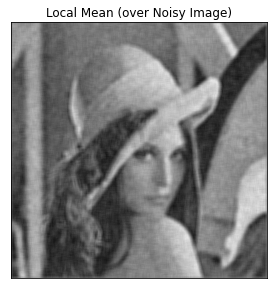

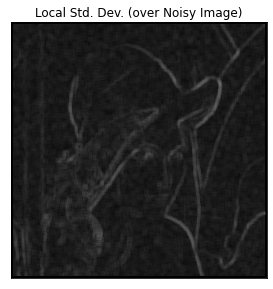

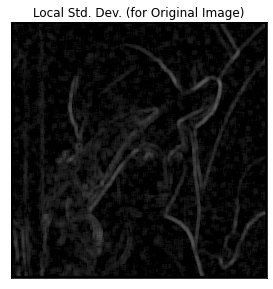

In [9]:
# define local window size
N = 5

# define NxN mean filter
filterMean = np.ones((N,N))
filterMean /= filterMean.sum()

# calculate local mean over NxN window
imgLocalMean = signal.convolve2d(imgNoisy, filterMean, mode='same', boundary='fill', fillvalue=128)

# display local mean
my_display_actual_size(imgLocalMean, 'Local Mean (over Noisy Image)')

# define epsilon
epsilon = 1e-6

# calculate local variance over NxN window
imgLocalSquare = imgNoisy * imgNoisy
imgLocalMeanSquare = signal.convolve2d(imgLocalSquare, filterMean, mode='same', boundary='fill', fillvalue=128)
# use epsilon to prevent division by 0
imgLocalVariance = np.maximum(imgLocalMeanSquare - imgLocalMean * imgLocalMean, epsilon)

# display local standart deviation
my_display_actual_size(np.sqrt(imgLocalVariance), 'Local Std. Dev. (over Noisy Image)')

# calculate local signal variance over NxN window
imgLocalVarianceOrig = np.maximum(imgLocalVariance - noise_Std * noise_Std, 0.0)

# display local standart deviation for original signal
my_display_actual_size(np.sqrt(imgLocalVarianceOrig), 'Local Std. Dev. (for Original Image)')


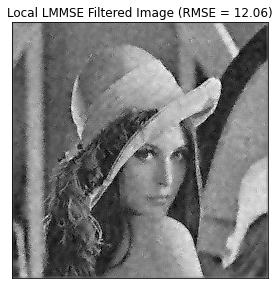

In [10]:
# implement the local LMMSE filter
imgFilteredLocalLMMSE = imgLocalMean + imgLocalVarianceOrig/imgLocalVariance*(imgNoisy - imgLocalMean)

# calculate filtering error
rmse_LMMSE = my_RMSE(imgLum, imgFilteredLocalLMMSE)

# display local LMMSE filtered image
my_display_actual_size(imgFilteredLocalLMMSE, 'Local LMMSE Filtered Image (RMSE = {:.2f})'.format(rmse_LMMSE))


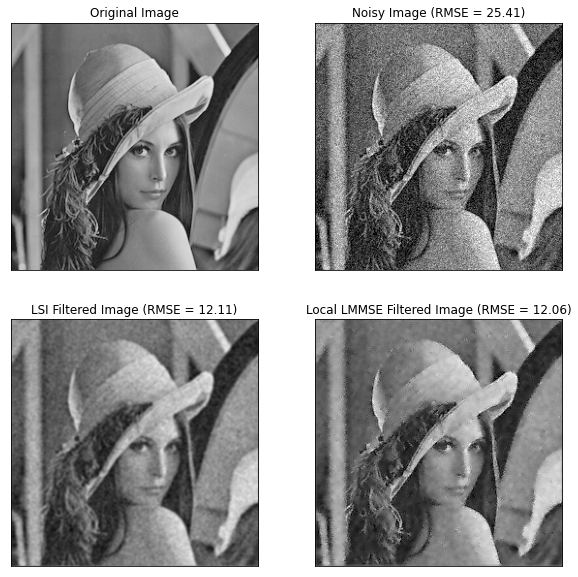

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(imgLum, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([])
plt.title('Original Image')
plt.subplot(222), plt.imshow(imgNoisy, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([])
plt.title('Noisy Image (RMSE = {:.2f})'.format(rmse_Noisy))
plt.subplot(223), plt.imshow(imgFilteredLSI, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([])
plt.title('LSI Filtered Image (RMSE = {:.2f})'.format(rmse_LSI))
plt.subplot(224), plt.imshow(imgFilteredLocalLMMSE, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([])
plt.title('Local LMMSE Filtered Image (RMSE = {:.2f})'.format(rmse_LMMSE))
plt.show()
plt.close()

---------------------------------------------------------------
### **Part 4:** Nonlinear Filtering using the Median Filter


In [16]:
# read salt and pepper noisy image 
image_file_2 = r'/Noise_salt_and_pepper.png'
image_path_2 = image_folder + image_file_2
imgRGB_2 = io.imread(image_path_2)

if imgRGB_2.ndim >= 3:
    # calculate the luminance image
    imgLum_SaltPepper = my_imgLuminance(imgRGB_2)
else:
    imgLum_SaltPepper = imgRGB_2

# display noisy image
plt.figure(figsize=(4,8))
plt.subplot(111), plt.imshow(imgLum_SaltPepper, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([])
plt.title('Noisy Image')
plt.show()
plt.close()

FileNotFoundError: No such file: 'C:\Users\Metin\Desktop\EE421\Week10\Noise_salt_and_pepper.png'

In [14]:
# define local window size
W = 3

# get image size
height, width = imgLum_SaltPepper.shape

# make a copy for the boundaries
imgFilteredMedian = imgLum_SaltPepper.copy()

# implement the median filter
for n in range(W, height-W):
    for m in range(W, width-W):
        winLocal = imgLum_SaltPepper[n-W:n+W, m-W:m+W] # (2W+1)x(2W+1) window
        imgFilteredMedian[n,m] = np.median(winLocal)
        
plt.figure(figsize=(9,8))
plt.subplot(121), plt.imshow(imgLum_SaltPepper, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([])
plt.title('Noisy Image')
plt.subplot(122), plt.imshow(imgFilteredMedian, cmap='gray', vmin=0, vmax=255)
plt.xticks([]), plt.yticks([])
plt.title('Median Filtered Image')
plt.show()
plt.close()


NameError: name 'imgLum_SaltPepper' is not defined